In [57]:
from fastai.vision.all import *
from kornia import rgb_to_grayscale
import torch.nn as nn
import warnings
import random, textwrap
import os, glob
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [177]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # V1 layers
        self.V1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=7 // 2),  # + self.vfb,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # V2 layers
        self.V2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # V4 layers
        self.V4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # IT layers
        self.IT = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # decoding layer
        self.decoder = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(512, 2),
        )

    def forward(self, inp):

        v4 = torch.zeros(512, 256, 3, 3).to("cuda")
        vIT = torch.zeros(256, 128, 3, 3).to("cuda")
        v2 = torch.zeros(256, 128, 3, 3).to("cuda")
        v1 = torch.zeros(128, 64, 3, 3).to("cuda")
        x = inp
        
        v1 = self.V1(x)
        v2 = self.V2(v1)
        v4 = self.V4(v2)
        vIT = self.IT(v4)
        out = self.decoder(vIT)

        return out


def label_from_path(path):
    [orient, first, second] = path.stem.split("_")
    return "same" if (first == second) else "different"

def plot_filters_multi_channel(t):
    
    #get the number of kernels
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    
def display_images(
    images: [Image.Image], 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.tight_layout()

        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size);


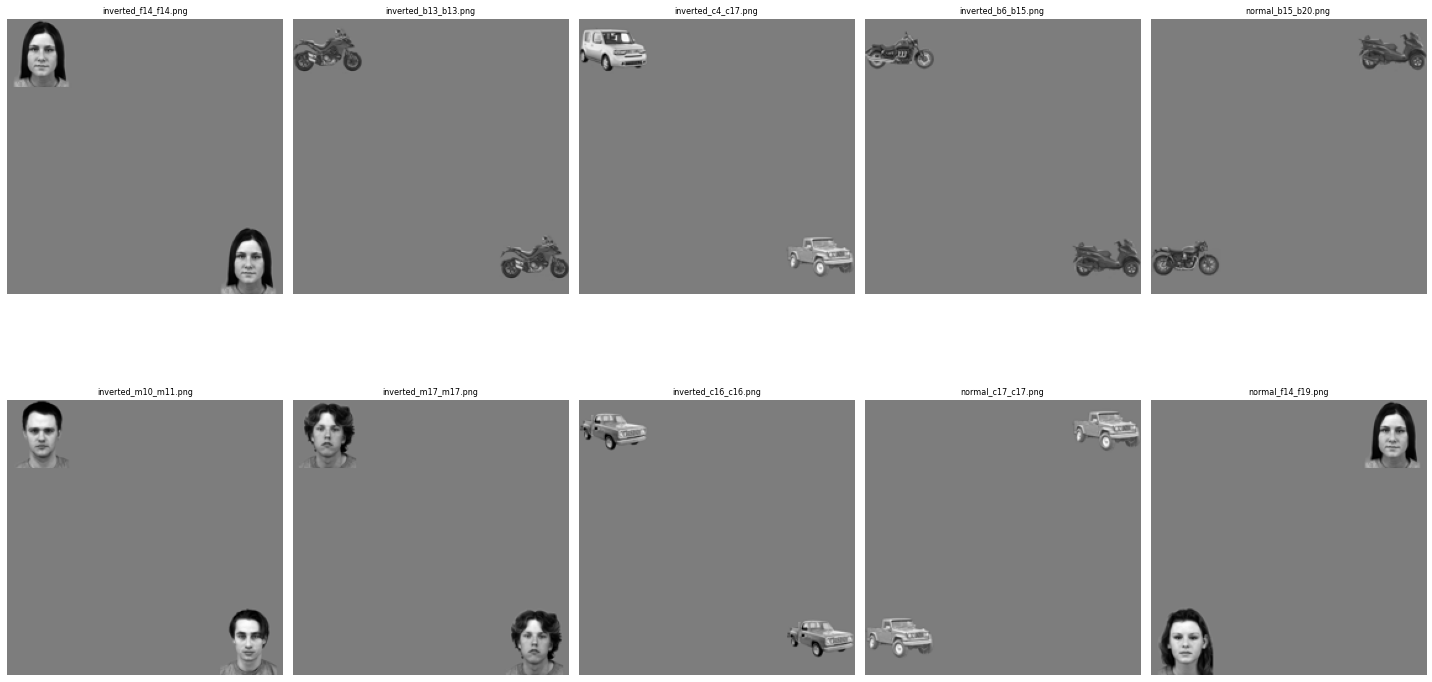

In [188]:
root = r"C:\Users\45027900\Desktop\model_old\data\original"
outroot = os.path.join(root, 'samediff')
os.makedirs(outroot, exist_ok=True)
stim_paths = glob.glob(os.path.join(root, '*.png'))

cat_index = ["m","f","c","b"]
stim_order = np.array([[[1,1],[2,2],[3,3],[4,4],[5,5],[16,16],[17,17],[18,18],[19,19],[20,20],[1,20],[2,19],[3,18],[4,17],[5,16],[6,15],[7,14],[8,13],[9,12],[10,11]],[[6,6],[7,7],[8,8],[9,9],[10,10],[11,11],[12,12],[13,13],[14,14],[15,15],[10,1],[9,2],[8,3],[7,4],[6,5],[11,16],[12,17],[13,18],[14,19],[15,20]],[[16,16],[17,17],[18,18],[19,19],[20,20],[1,1],[2,2],[3,3],[4,4],[5,5],[1,20],[2,19],[3,18],[4,17],[5,16],[10,1],[9,2],[8,3],[7,4],[6,5]],[[11,11],[12,12],[13,13],[14,14],[15,15],[6,6],[7,7],[8,8],[9,9],[10,10],[6,15],[7,14],[8,13],[9,12],[10,11],[11,16],[12,17],[13,18],[14,19],[15,20]]])

stims_dict = {path: {'category': os.path.basename(path)[0], 'id':os.path.basename(path).split('.')[0][1:]} for path in stim_paths}

orientations = ['normal','inverted']
ordered_stim_dict = {orientation : {cat_index[category_id]: {stim_pair_id: {'stim1':stim_order[category_id, stim_pair_id, 0], 'stim2':stim_order[category_id, stim_pair_id, 1], 'same':stim_order[category_id, stim_pair_id, 0] == stim_order[category_id, stim_pair_id, 1]} for stim_pair_id in range(len(stim_order[category_id]))} for category_id in range(stim_order.shape[0])} for orientation in orientations}

# for orientation in orientations:
#     for cat_id in ordered_stim_dict[orientation]:
#         for pair_id in ordered_stim_dict[orientation][cat_id]:
#             bg = (125,125,125)
#             base = Image.new('RGB', (224, 224), bg)

#             im1_path = os.path.join(root, cat_id + str(ordered_stim_dict[orientation][cat_id][pair_id]['stim1']) + '.png')
#             im2_path = os.path.join(root, cat_id + str(ordered_stim_dict[orientation][cat_id][pair_id]['stim2']) + '.png')

#             im1 = Image.open(im1_path)
#             im2 = Image.open(im2_path)
            
#             if orientation == 'normal':
#                 im1.thumbnail((224 // 4, 224//4))
#                 base.paste(im1, (224 - im1.size[0],0))
#                 im2.thumbnail((224//4, 224//4))
#                 base.paste(im2, (0, 224 - im2.size[0]))
#             else:
#                 im1.thumbnail((224 // 4, 224//4))
#                 base.paste(im1, (0, 0))
#                 im2.thumbnail((224//4, 224//4))
#                 base.paste(im2, (224 - im2.size[0], 224 - im2.size[0]))
            
#             fiename = orientation + '_' + cat_id + str(ordered_stim_dict[orientation][cat_id][pair_id]['stim1']) + '_' + cat_id + str(ordered_stim_dict[orientation][cat_id][pair_id]['stim2']) + '.png'
#             out_dir = os.path.join(outroot, fiename)

#             base.save(out_dir)

pairs = glob.glob(os.path.join(outroot, '*.png'))
display_images([Image.open(i) for i in random.sample(pairs, 10)])


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck

Showing first batch...


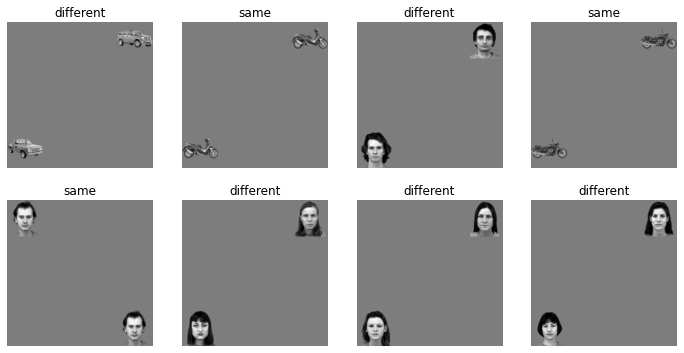

In [209]:
# init dataloaders
stim_path = Path(outroot)
fnames = sorted(get_image_files(stim_path))
dls = ImageDataLoaders.from_path_func(stim_path, fnames, label_from_path, valid_pct=0.2, seed=42, shuffle=True, device='cuda', bs=8, batch_tfms=[Normalize.from_stats(*imagenet_stats)])
print('\nShowing first batch...')
dls.show_batch()

In [210]:
## init net and pass one image
net = Net().cuda()
weights_path = Path(r"C:\Users\45027900\Desktop\project\net.pt")

if weights_path.is_file():
    ckpt_data = torch.load(weights_path)
    state_dict = ckpt_data
    state_dict.pop("FB.0.weight") 
    state_dict.pop("FB.0.bias") 
    state_dict["decoder.2.weight"] = torch.rand((2, 512))
    state_dict["decoder.2.bias"] = torch.rand((2))
    net.load_state_dict(state_dict)
    print('weights loaded!')

image = dls.one_batch()[0][0].unsqueeze(0)
net(image).shape

weights loaded!


torch.Size([1, 2])

In [211]:
#init learner
def split_layers(model):
    return [params(model.V1),params(model.V2),params(model.V4),params(model.IT), params(model.decoder)]
# def split_layers(model):
#     return [params(model.decoder)]

# print(len(split_layers(net)[3]))
learner = Learner(dls, net, splitter=split_layers, metrics=accuracy)
learner.freeze_to(-1)
learner.summary()


Net (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9472       False     
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     8 x 128 x 56 x 56   
Conv2d                                    73856      False     
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     8 x 256 x 28 x 28   
Conv2d                                    295168     False     
ReLU                                                           
MaxPool2d                                                      
___________________________________________________________

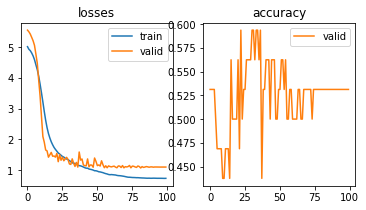

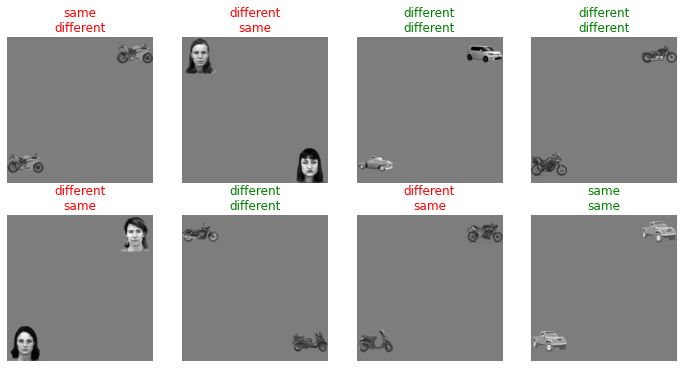

In [212]:
# learner.lr_find()
# learner.unfreeze()
with learner.no_logging():
    learner.fit_one_cycle(100)
    
recorder = learner.recorder
metrics =  np.stack(recorder.values)
names = recorder.metric_names[1:-1]
n = len(names) -1
fig, axs = subplots(1, 2)
axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]

for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
        
learner.show_results()

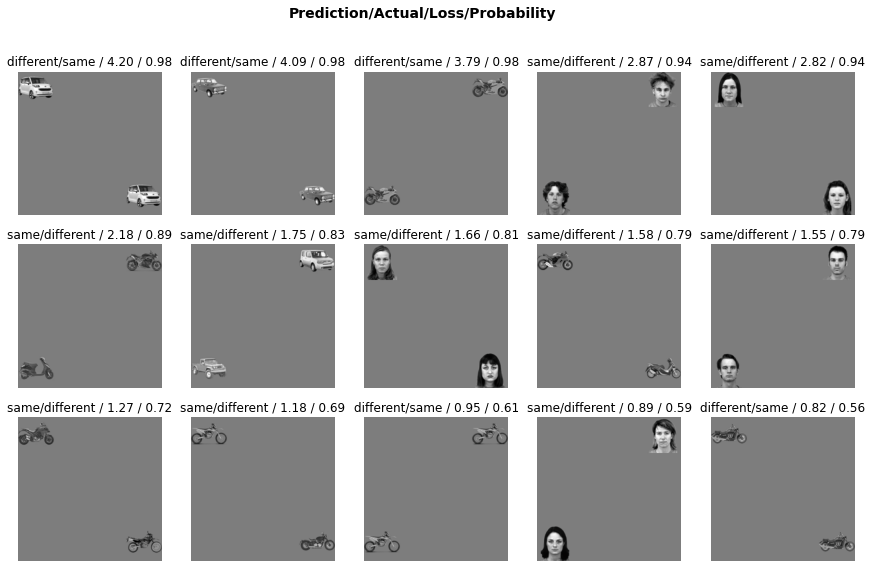

In [213]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(15)

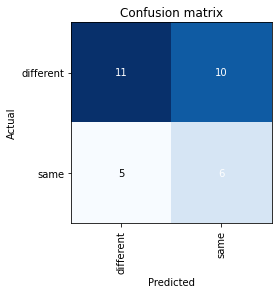

In [214]:
interp.plot_confusion_matrix()

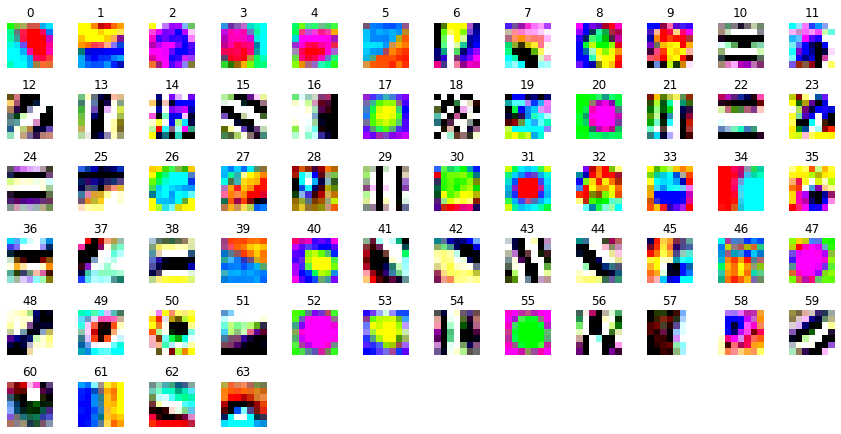

In [215]:
weights = learner.model.V1[0].weight.data.cpu()
def plot_filters_multi_channel(t):
    
    #get the number of kernels
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    
plot_filters_multi_channel(weights)